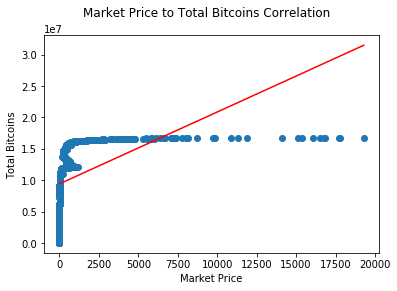

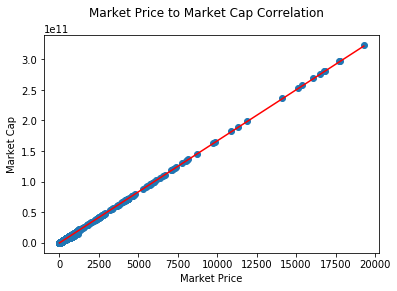

/Users/aman/anaconda3/envs/CryptoIndices/lib/python3.6/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


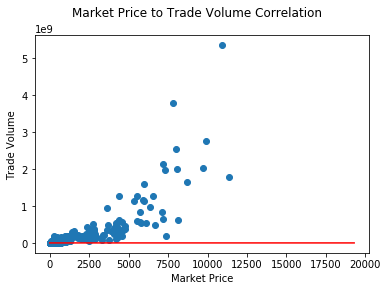

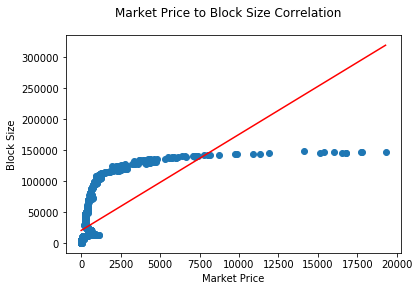

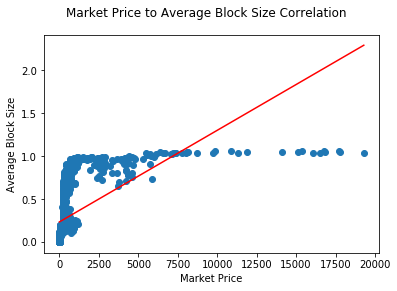

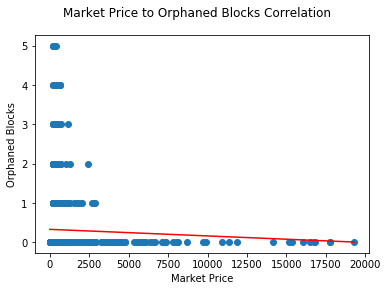

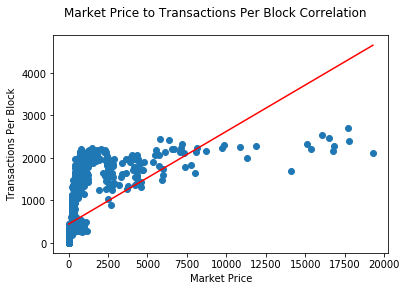

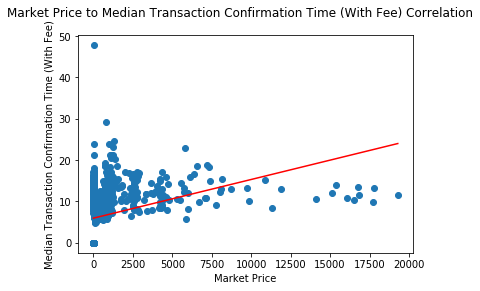

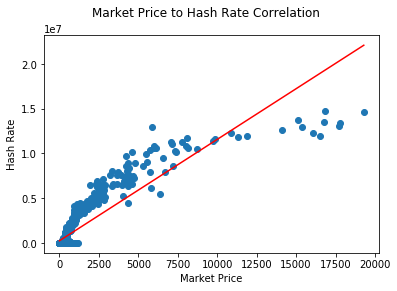

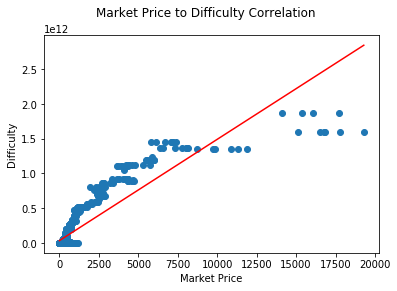

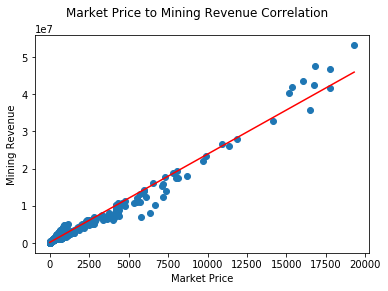

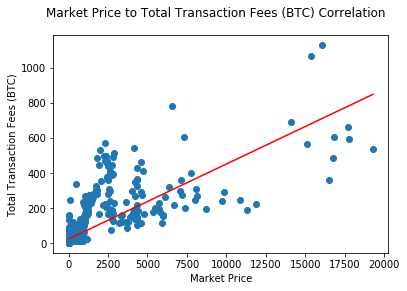

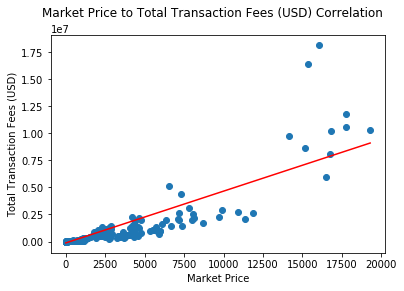

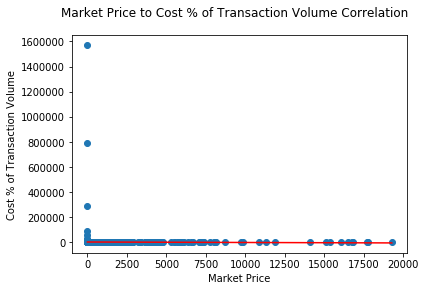

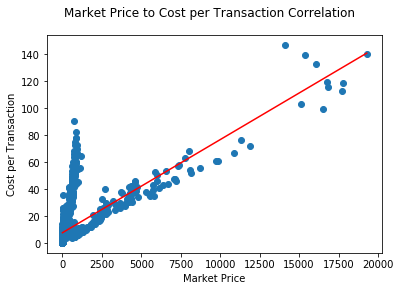

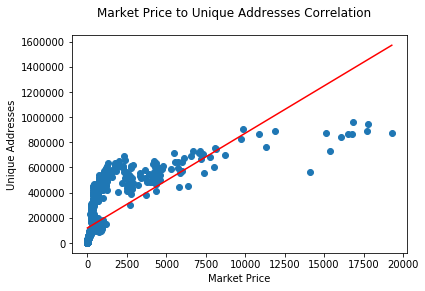

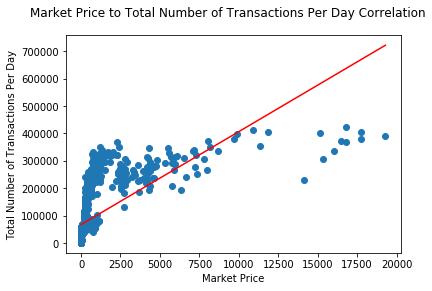

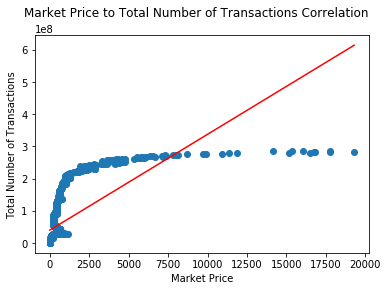

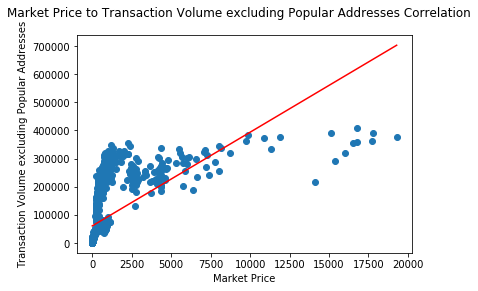

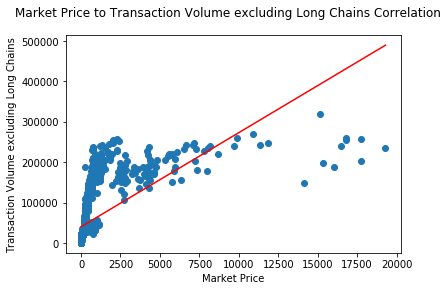

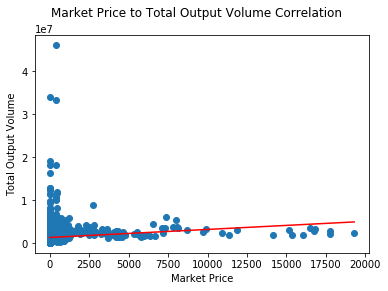

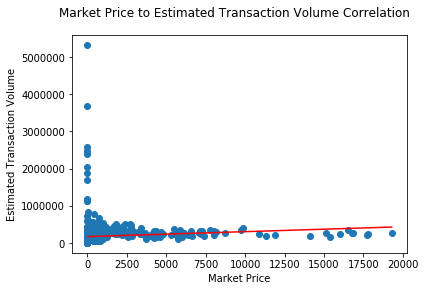

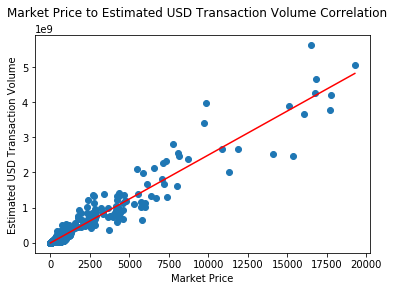

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 25 19:26:02 2017

@author: Aman
"""
import requests, json, datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Constants import API_METRICS_MAPPING, BASE_URL

# Enabling logging
import logging
logger = logging.getLogger("BlockchainInfoWrapper")
logger.setLevel(logging.INFO)
logger.disabled = False    # Toggle to enable/disable logging
formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(name)s:%(message)s')

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

class Wrapper(object):

    time_span = "all" #Timespan possible values = all, 1years, 2years, 3years, 180days, 90days, 30days, 1days
    format = "json"

    def __init__(self, chart_url):
        self.chart_url = chart_url
        self.full_url = '{}{}?timespan={}&format={}'.format(BASE_URL, self.chart_url, self.time_span, self.format)

    def get_json(self):
        r = requests.get(self.full_url)
        if r.status_code == 200:
            return json.loads(r.content)
        else:
            return 0

    @staticmethod
    def timestamp_to_date(timestamp):
        return datetime.datetime.fromtimestamp(float(timestamp)).strftime("%b %d, %Y")

# Plotting graph using Matplotlib
def correlation_plot(x, y, title, xlabel, ylabel):
    fig = plt.figure()
    fig.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y)
    # Regression Line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
    plt.show()

if __name__ == '__main__':

    df = pd.DataFrame(columns=['Timestamp'])

    for metrics in API_METRICS_MAPPING.keys():
        wrapper = Wrapper(chart_url=API_METRICS_MAPPING[metrics]['url'])
        finalJson = wrapper.get_json()
        data = finalJson.get('values', [])
        metricsName = finalJson.get('name', '')
        logger.debug("Iterating over: " + metricsName)
        logger.debug(data)
        if data != 0 and finalJson.get('period','') == 'day':
            for i, dict in enumerate(data):
                for key in dict.keys():
                    if not dict['x'] in df['Timestamp']:
                        df.loc[i, 'Timestamp'] = dict['x']
                        df.loc[i, 'Date'] = wrapper.timestamp_to_date(dict['x'])
                    df.loc[i, metrics] = dict['y']
            logger.debug("Dataframe after insertion of " + metricsName + " is: \n" + df.to_string())
        else:
            logger.debug("No data exist for metrics: " + metricsName)

logger.debug("Final data frame:\n" + df.to_string())

# Correlation graph between Bitcoin Price and Other metrics
for col in list(df):
    if col != 'Date' and col != 'Timestamp' and col != 'Market Price':
        title = "Market Price to " + col + " Correlation"
        correlation_plot(df['Market Price'], df[col], title, 'Market Price', col)


